# AI


### Instalação e importação das bibliotecas e importação do dataset

In [ ]:
pip install modAL

In [ ]:
pip install skorch

     |████████████████████████████████| 155 kB 2.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from skorch import NeuralNetClassifier
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import tensorflow as tf
from modAL.models import ActiveLearner
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Adapt the path before running

# Import and pre-processing of data.

# Part of the code is commented out so it is not necessary to process the data 
# every time you run the program. We have already done the import of the data 
# processed afterwards.


# dataset = get_files('dataset.csv')
# weights = get_files('Symptom-severity.csv')

# df = reshape_dataset(dataset, weights)
# target = reshape_target(dataset)

##df = get_files('pro.csv')
##target = get_files('target.csv')

# dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI/dataset.csv")

# weights = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI/Symptom-severity.csv")

df = pd.read_csv(
   "/content/drive/MyDrive/Colab Notebooks/AI/pro.csv") # nao precisa correr o processamento toda vez

target = pd.read_csv(
   "/content/drive/MyDrive/Colab Notebooks/AI/target.csv") # nao precisa correr o processamento toda vez

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Definição das funções

In [ ]:
def get_files(name):
    """ ... """ 

    home_dir = os.getcwd()
    file = pd.read_csv(os.path.join(home_dir, name))
    
    return file

In [ ]:
def reshape_dataset(dataset, weights):

    a = weights['Symptom'].unique()
    
    df = pd.DataFrame(index = np.arange(dataset.shape[0]),columns = a)
    del df['Disease']
    df = df.fillna(0)
    
    for j in range(len(dataset) - 1):
      for symp in a: 
        if symp in dataset.loc[j].str.strip().values:
          weigth = weights.loc[lambda s: weights['Symptom'] == symp]
          df[symp][j] = 1 * weigth['weight'].values[0]

    return df

In [ ]:
def reshape_target(dataset):
    
    a = dataset['Disease'].unique()
    a = [i.strip() for i in a]

    disease_values = pd.DataFrame(np.arange(len(a)), index = a).transpose()

    df_target = pd.DataFrame()

    for j in range(dataset.shape[0]):
      for targ in a: 
        if targ in dataset['Disease'].loc[j].strip():
          df_target = df_target.append(disease_values[targ])

    return df_target, disease_values

In [ ]:
def save_file(df,name):
    
    home_dir = "/content/drive/MyDrive/Colab Notebooks/AI/"
    df.to_csv(os.path.join(home_dir, name+ '.csv'))

In [ ]:
def data_preprocessing(df, target):
    target = target.drop(columns=target.columns[0])
    target = target.astype(int)
    target = target['0']
    df = df.drop(columns ='Unnamed: 0')
    return df, target

In [ ]:
def train_test_split(X, y, percentage):

    idx = int(X.shape[0]*(1-percentage))

    X_train, X_test, y_train, y_test = X[:idx], X[idx:], y[:idx], y[idx:]

    X_train = X_train.reshape(idx, 1, X.shape[1]) 
 
    X_test = X_test.reshape(X.shape[0]-idx, 1, X.shape[1]) 

    return X_train, X_test, y_train, y_test

In [ ]:
def initial_data_assemble(X_train, y_train, n_initial):

    # assemble initial data

    initial_idx = np.random.choice(range(len(X_train)), size = n_initial, replace = False)
    X_initial = X_train[initial_idx] 
    y_initial = y_train[initial_idx].astype(int)

    return initial_idx, X_initial, y_initial

In [ ]:
def generate_pool(X_train, y_train, initial_idx):

    # generate the pool
    # remove the initial data from the training dataset

    idx = int(X_train.shape[0]*0.1)

    X_pool = np.delete(X_train, initial_idx, axis = 0)[:idx]
    y_pool = np.delete(y_train, initial_idx, axis = 0)[:idx]    

    return X_pool, y_pool

### Classifier

In [ ]:
# target, values = reshape_target(dataset)

In [ ]:
# build class for the skorch API
class Torch_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(
                                nn.Linear(131, 64),
                                nn.Linear(64, 41), 
        )

    def forward(self, x):
        out = x
        out = self.fcs(out)
        out = out.view(-1, 41)

        return out

In [ ]:
# create the classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = NeuralNetClassifier(Torch_Model,
                                criterion = nn.CrossEntropyLoss,
                                 optimizer = torch.optim.Adam,
                                 train_split = None,
                                 verbose = 1,
                                 device = device)

In [ ]:
df_preprocessed, target_preprocessed = data_preprocessing(df, target)

df_tensor = torch.utils.data.TensorDataset(torch.Tensor(np.array(df_preprocessed)), torch.Tensor(target_preprocessed))
 
dataloader = DataLoader(df_tensor, shuffle = True, batch_size = df.shape[0]) # batch_size = how many samples per batch to load (default: 1)
X, y = next(iter(dataloader))
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)

initial_idx, X_initial, y_initial = initial_data_assemble(X_train, y_train, 10)

X_pool, y_pool = generate_pool(X_train, y_train, initial_idx)

In [ ]:
from modAL.uncertainty import entropy_sampling

learner = ActiveLearner(
    estimator = classifier,
    X_training = X_initial, 
    y_training = y_initial,
    query_strategy = entropy_sampling, 
    epochs = 30
)

accuracy = learner.score(X_train, y_train)
t_accuracy = learner.score(X_test, y_test)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        3.6413  0.0058
      2        2.5472  0.0065
      3        1.6751  0.0024
      4        1.0438  0.0025
      5        0.5861  0.0024
      6        0.3011  0.0025
      7        0.1540  0.0025
      8        0.0802  0.0025
      9        0.0451  0.0026
     10        0.0285  0.0028
     11        0.0184  0.0030
     12        0.0116  0.0030
     13        0.0074  0.0027
     14        0.0050  0.0027
     15        0.0037  0.0030
     16        0.0027  0.0038
     17        0.0021  0.0029
     18        0.0015  0.0025
     19        0.0012  0.0049
     20        0.0009  0.0032
     21        0.0006  0.0028
     22        0.0005  0.0030
     23        0.0004  0.0047
     24        0.0003  0.0058
     25        0.0002  0.0034
     26        0.0002  0.0071
     27        0.0002  0.0037
     28        0.0001  0.0040
     29        0.0001 

In [ ]:
# the active learning loop
accuracy_historial = [accuracy]
test_accuracy = [t_accuracy]

n_queries = 10

for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, 10)  
    learner.teach(
    X = X_pool[query_idx], y = y_pool[query_idx].astype(int), epochs = 40)
    
    accuracy_historial.append(learner.score(X_train, y_train))
    test_accuracy.append(learner.score(X_test, y_test))

    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis =  0)
    y_pool = np.delete(y_pool, query_idx, axis = 0)

prediction = learner.predict_proba(X_test)

Query no. 1
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        3.8050  0.0020
      2        2.9535  0.0035
      3        2.1989  0.0036
      4        1.5757  0.0033
      5        1.0881  0.0032
      6        0.7259  0.0031
      7        0.4727  0.0027
      8        0.3052  0.0032
      9        0.1934  0.0028
     10        0.1141  0.0040
     11        0.0620  0.0040
     12        0.0337  0.0034
     13        0.0198  0.0045
     14        0.0125  0.0044
     15        0.0081  0.0047
     16        0.0051  0.0053
     17        0.0032  0.0049
     18        0.0021  0.0031
     19        0.0015  0.0053
     20        0.0011  0.0057
     21        0.0009  0.0034
     22        0.0008  0.0055
     23        0.0007  0.0039
     24        0.0006  0.0043
     25        0.0005  0.0033
     26        0.0005  0.0043
     27        0.0004  0.0047
     28        0.0003  0.0076
     29   

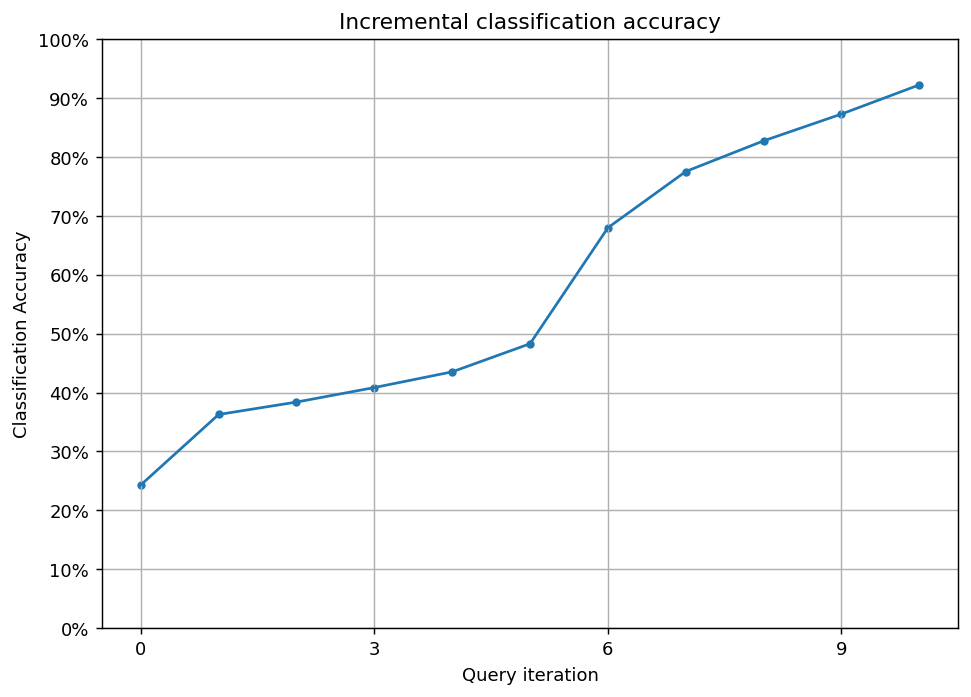

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8.5, 6), dpi = 130)

ax.plot(accuracy_historial)
ax.scatter(range(len(accuracy_historial)), accuracy_historial, s = 13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins = 5, integer = True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins = 10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))

ax.set_ylim(bottom = 0, top = 1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
import statistics 
import sklearn

train_acc = statistics.mean(accuracy_historial)
test_acc = statistics.mean(test_accuracy)
auc = sklearn.metrics.roc_auc_score(np.reshape(y_test, (len(y_test), 1)), prediction, multi_class = 'ovr') 

print("Train accuracy mean: %4.2f " % (train_acc * 100))
print("Test accuracy mean:  %4.2f" % (test_acc * 100))
print("Area unde the ROC curve: %4.2f" % auc)

Train accuracy mean: 58.13 
Test accuracy mean:  58.31
Area unde the ROC curve: 0.97


In [ ]:
from tabulate import tabulate 
import math 

classes = []; 

for i in range(len(prediction)):
  classes.append(np.argmax(prediction[i]))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, classes)

FP = confusion_matrix.sum(axis = 0) - np.diagonal(confusion_matrix)
FN = confusion_matrix.sum(axis = 1) - np.diagonal(confusion_matrix)
TP = np.diagonal(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity / recall
sensitivity = TP/(TP + FN)
# Specificity 
specificity = TN/(TN + FP) 
# Precision / positive predictive value
ppv = TP/(TP + FP)
# Negative predictive value
npv = TN/(TN + FN)

# Overall accuracy
acc = (TP + TN) / (TP + FP + FN + TN)

metrics = []; 
header = ['Disease', 'Sensitivity', 'Specificity', 'Positive predictive value', 'Negative predictive value', 'Accuracy']
diseases = ['Fungal infection',	'Allergy',	'GERD',	'Chronic cholestasis',	'Drug Reaction',	'Peptic ulcer disease',	'AIDS',	'Diabetes',	'Gastroenteritis',	'Bronchial Asthma',	'Hypertension',	'Migraine',	'Cervical spondylosis',	'Paralysis (brain hemorrhage)',	'Jaundice',	'Malaria',	'Chicken pox',	'Dengue',	'Typhoid',	'Hepatitis A',	'Hepatitis B',	'Hepatitis C',	'Hepatitis D',	'Hepatitis E',	'Alcoholic hepatitis',	'Tuberculosis',	'Common Cold',	'Pneumonia',	'Dimorphic hemmorhoids (piles)', 'Heart attack',	'Varicose veins',	'Hypothyroidism',	'Hyperthyroidism',	'Hypoglycemia',	'Osteoarthristis',	'Arthritis',	'(vertigo) Paroymsal Positional Vertigo',	'Acne',	'Urinary tract infection',	'Psoriasis',	'Impetigo']

for i in range(1, 41):
  metrics.append([diseases[i], sensitivity[i], specificity[i], ppv[i], npv[i], acc[i]])
  
for i in range(0, 40):
  for j in range(1, 5):
    if math.isnan(metrics[i][j]):
      metrics[i][j] = 0
  if math.isnan(ppv[i]):
    ppv[i] = 0
      
values = sklearn.metrics.precision_recall_fscore_support(y_test, classes, average = 'micro')
overall_acc = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
overall_npv = sum(TN) / (sum(TN) + sum(FN))
overall_speci = sum(TN) / (sum(TN) + sum(FP)) 

metrics.append(['Micro-averaging measurements:', values[0], overall_speci, values[1], overall_npv, overall_acc])


print(tabulate(metrics, header, tablefmt = "github", numalign = "center"))

SyntaxError: ignored

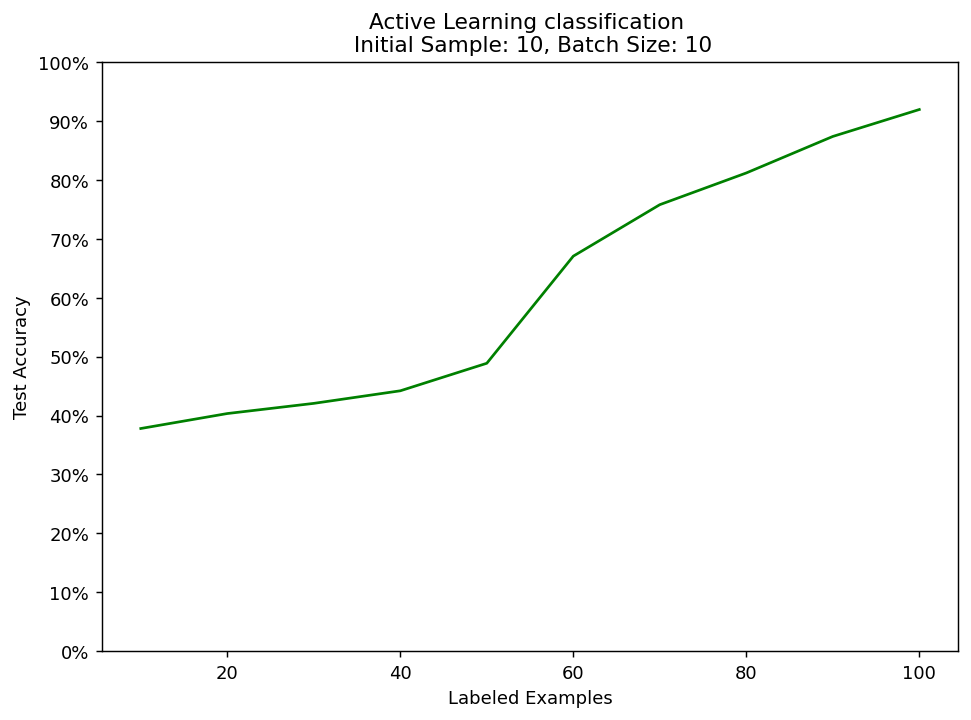

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8.5, 6), dpi = 130)

ax.plot(range(10, 101, 10), test_accuracy[1:11], color = 'green')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins = 5, integer = True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins = 10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))

ax.set_ylim(bottom = 0, top = 1)

ax.set_title('Active Learning classification \n Initial Sample: 10, Batch Size: 10')
ax.set_xlabel('Labeled Examples')
ax.set_ylabel('Test Accuracy')

plt.show()

In [ ]:
margin_accuracy = test_accuracy

In [ ]:
uncertainty_accuracy = test_accuracy

In [ ]:
entropy_accuracy = test_accuracy

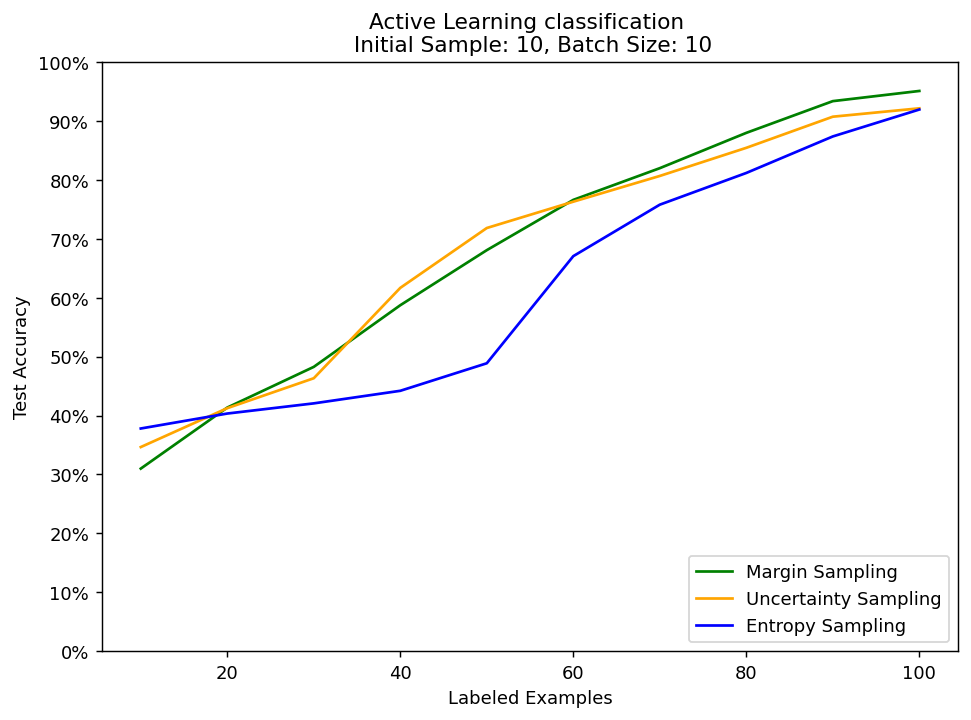

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8.5, 6), dpi = 130)

ax.plot(range(10, 101, 10), margin_accuracy[1:11], color = 'green', label = 'Margin Sampling')
ax.plot(range(10, 101, 10), uncertainty_accuracy[1:11], color = 'orange', label = 'Uncertainty Sampling')
ax.plot(range(10, 101, 10), entropy_accuracy[1:11], color = 'blue', label = 'Entropy Sampling')
ax.legend(loc = 'lower right')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins = 5, integer = True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins = 10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))

ax.set_ylim(bottom = 0, top = 1)

ax.set_title('Active Learning classification \n Initial Sample: 10, Batch Size: 10')
ax.set_xlabel('Labeled Examples')
ax.set_ylabel('Test Accuracy')

plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/AI/plot.png', dpi = 1840)